# Import

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import pytorch_lightning as pl
from torchmetrics import F1Score
from torchmetrics import MetricCollection

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import multiprocessing
from tqdm import tqdm

In [2]:
# multiprocessing.set_start_method('fork')

In [3]:
pl.seed_everything(seed=42)

Seed set to 42


42

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# MobileNetV1

In [5]:
class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int,
    ):
        super().__init__()
        self.in_channels = in_channels

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=in_channels,
                kernel_size=(3, 3),
                padding=1,
                stride=stride,
                groups=in_channels,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(1, 1),
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

In [6]:
class MobileNetV1(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        depth_multiplier: float = 1.0,
        resolution_multiplier: float = 1.0,
    ):
        super().__init__()
        self.depth_multiplier = depth_multiplier
        self.resolution_multiplier = resolution_multiplier
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=int(32 * self.depth_multiplier),
                kernel_size=(3, 3),
                padding=1,
                stride=2,
            ),
        )

        # (in_channels, out_channels, stride)
        config = (
            (32, 64, 1),
            (64, 128, 2),
            (128, 128, 1),
            (128, 256, 2),
            (256, 256, 1),
            (256, 512, 2),
            (512, 512, 1),
            (512, 512, 1),
            (512, 512, 1),
            (512, 512, 1),
            (512, 512, 1),
            (512, 1024, 2),
            (1024, 1024, 1),
        )

        depthwise_blocks = []
        for in_channels, out_channels, stride in config:
            depthwise_blocks.append(
                DepthwiseSeparableConvBlock(
                    in_channels=int(in_channels * self.depth_multiplier),
                    out_channels=int(out_channels * self.depth_multiplier),
                    stride=stride,
                )
            )
        self.depthwise_blocks = nn.Sequential(*depthwise_blocks)
        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=int(1024 * self.depth_multiplier),
                out_features=num_classes,
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv_1(x)
        out = self.depthwise_blocks(out)
        out = self.avg_pool(out)
        out = self.classifier(out)
        return out

In [7]:
model = MobileNetV1(
    in_channels=3,
    num_classes=1_000,
    depth_multiplier=0.75,
    resolution_multiplier=1.0,
)

In [8]:
model(torch.randn(32, 3, 224, 224)).shape

torch.Size([32, 1000])

In [9]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,585,536 trainable parameters


# MobileNetV2

In [10]:
class InvertedResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int,
        expansion_factor: int = 6,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        hid_channels: int = int(in_channels * expansion_factor)

        if in_channels == hid_channels:
            self.pointwise_conv_1 = nn.Sequential(nn.Identity())
        else:
            self.pointwise_conv_1 = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=hid_channels,
                    kernel_size=(1, 1),
                    stride=1,
                    bias=False,
                ),
                nn.BatchNorm2d(hid_channels),
                nn.ReLU6(inplace=True),
            )
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=hid_channels,
                out_channels=hid_channels,
                kernel_size=(3, 3),
                padding=1,
                stride=stride,
                groups=hid_channels,
                bias=False,
            ),
            nn.BatchNorm2d(hid_channels),
            nn.ReLU6(inplace=True),
        )
        self.pointwise_conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hid_channels,
                out_channels=out_channels,
                kernel_size=(1, 1),
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
        )

        self.residual = (stride == 1) and (in_channels == out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.pointwise_conv_1(x)
        out = self.depthwise_conv(out)
        out = self.pointwise_conv_2(out)

        if self.residual:
            return out + x
        return out

In [11]:
class MobileNetV2(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
    ):
        super().__init__()

        # in_channels, expansion_factor, out_channels, repeated, stride
        config = (
            (32, 1, 16, 1, 1),
            (16, 6, 24, 2, 2),
            (24, 6, 32, 3, 2),
            (32, 6, 64, 4, 2),
            (64, 6, 96, 3, 1),
            (96, 6, 160, 3, 2),
            (160, 6, 320, 1, 1),
        )

        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=32,
                kernel_size=(3, 3),
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
        )

        self.bottlenecks = nn.ModuleList([])
        for in_channels, exp_factor, out_channels, repeat, stride in config:
            bottleneck = []
            # The first layer of each sequence has a stride 's' and all others use stride 1
            for r in range(repeat):
                bottleneck.append(
                    InvertedResidualBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        stride=stride,
                        expansion_factor=exp_factor,
                    )
                )
                in_channels = out_channels
                stride = 1
            
            self.bottlenecks.append(nn.Sequential(*bottleneck))

        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=320,
                out_channels=1280,
                kernel_size=(1, 1),
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True),
        )

        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=1280,
                out_features=num_classes,
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv_1(x)
        
        for block in self.bottlenecks:
            out = block(out)

        out = self.conv_2(out)
        out = self.avg_pool(out)
        out = self.classifier(out)
        
        return out

In [12]:
mobile_net_v2 = MobileNetV2(
    in_channels=3,
    num_classes=1000,
)

In [13]:
print(f'The model has {count_parameters(mobile_net_v2):,} trainable parameters')

The model has 3,504,872 trainable parameters


In [14]:
mobile_net_v2(torch.randn(32, 3, 224, 224)).shape

torch.Size([32, 1000])

# Competition

https://www.kaggle.com/competitions/journey-springfield/

## Transforms

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=(0.6, 1.5), contrast=(0.6, 1.5)),
    transforms.GaussianBlur(3),
    transforms.RandomRotation((-60, 60)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## Data load

In [16]:
train_dataset = ImageFolder('~/Downloads/journey-springfield/train/simpsons_dataset')
test_dataset = ImageFolder('~/Downloads/journey-springfield/testset')

In [17]:
train_size = int(len(train_dataset) * 0.75)
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [18]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = train_transform

test_dataset.transform = val_transform

In [19]:
train_dataset.dataset.transforms

In [20]:
classes = [sample[1] for sample in train_dataset.dataset.samples]

<Axes: ylabel='Count'>

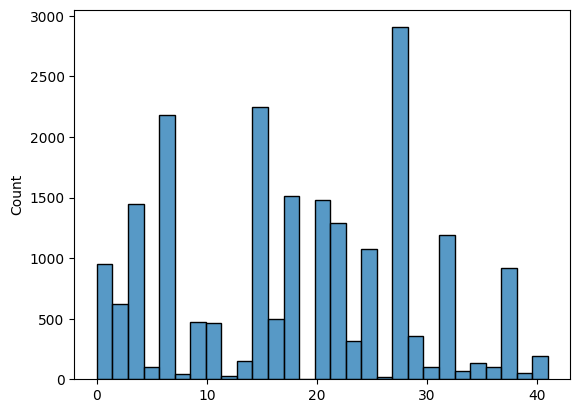

In [21]:
sns.histplot(x=classes)

In [22]:
class_dist = pd.Series(classes).value_counts()

weights = 1 / class_dist.values
class_weights = dict(zip(class_dist.index, weights))

sample_weights = [class_weights[train_dataset.dataset[ind][1]] for ind in train_dataset.indices]

In [23]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

In [24]:
batch_size: int = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=8,
    persistent_workers=True,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    persistent_workers=True,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    persistent_workers=True,
    pin_memory=True,
)

In [25]:
len(train_dataset), len(train_loader), len(sample_weights)

(15699, 491, 15699)

In [26]:
targets = []
for batch in tqdm(train_loader):
    img, target = batch[0], batch[1]
    targets += target.detach().numpy().tolist()
    # print(img.shape, model(img).shape)
    # break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491/491 [00:28<00:00, 16.97it/s]


<Axes: ylabel='Count'>

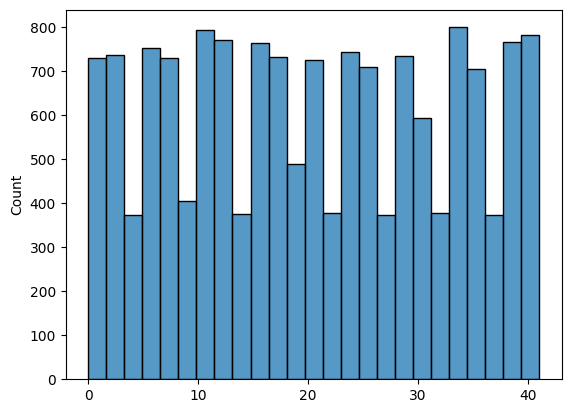

In [27]:
sns.histplot(x=targets)

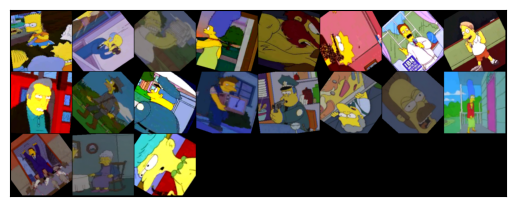

In [28]:
imgs = make_grid(batch[0])

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(imgs)

## Lightning Wrapper

In [29]:
class MobileNetLightning(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        t_max,
    ):
        super().__init__()

        self.model = model
        self.criterion = criterion
        self.t_max = t_max

        self.save_hyperparameters(ignore=['model', 'criterion'])

        metric = MetricCollection({'f1': F1Score(task='multiclass', num_classes=42)})
        self.train_metric = metric.clone(prefix='train/')
        self.valid_metric = metric.clone(prefix='valid/')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def evaluate(self, batch, metric_func):
        output = self.model(batch[0])
        
        # eval loss
        loss = self.criterion(output, batch[1])

        # eval metric
        metric = metric_func(output.argmax(dim=-1), batch[1])

        return loss, metric
    
    def training_step(self, batch, batch_idx):
        train_loss, train_metric = self.evaluate(batch, self.train_metric)
        self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_dict(train_metric, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return train_loss

    def validation_step(self, batch, batch_idx):
        valid_loss, val_metric = self.evaluate(batch, self.valid_metric)
        self.log("valid_loss", valid_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_dict(val_metric, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return valid_loss

    def predict_step(self, batch, batch_idx):
        pred = self.model(batch[0]).argmax(dim=-1)
        return pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), 1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.t_max,
        )
        return [optimizer], [scheduler]

In [30]:
class CustomClassificationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = None
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, output, target):
        self.loss = self.criterion(output, target)
        return self.loss

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

## Trainer

In [31]:
num_epochs = 10

In [32]:
mobile_net_v1 = MobileNetV1(
    in_channels=3,
    num_classes=len(train_dataset.dataset.classes),
    depth_multiplier=1,
    resolution_multiplier=1.0,
)
mobile_net_v2 = MobileNetV2(
    in_channels=3,
    num_classes=len(train_dataset.dataset.classes),
)

criterion = CustomClassificationLoss()

model = MobileNetLightning(
    model=mobile_net_v2,
    criterion=criterion,
    t_max=int(len(train_dataset) / batch_size + 1) * num_epochs,
)

In [33]:
trainer = pl.Trainer(
    accelerator='mps',
    max_epochs=num_epochs,
    accumulate_grad_batches=1,
    precision="16-mixed",
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True,
    gradient_clip_val=5,
    use_distributed_sampler=True,
)

Using 16bit Automatic Mixed Precision (AMP)
/Users/ruasvmv/common/lib/python3.9/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ruasvmv/common/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [34]:
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)


  | Name         | Type                     | Params | Mode 
------------------------------------------------------------------
0 | model        | MobileNetV2              | 2.3 M  | train
1 | criterion    | CustomClassificationLoss | 0      | train
2 | train_metric | MetricCollection         | 0      | train
3 | valid_metric | MetricCollection         | 0      | train
------------------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.111     Total estimated model params size (MB)
231       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/Users/ruasvmv/common/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


## Submit

In [35]:
predictions = trainer.predict(model, dataloaders=test_loader)

Predicting: |                                                                                                 …

In [36]:
labels = []
for pred in predictions:
    labels += pred.detach().numpy().tolist()

In [37]:
idx_to_class = {v: k for k, v in train_dataset.dataset.class_to_idx.items()}

In [38]:
submit = pd.read_csv('~/Downloads/journey-springfield/sample_submission.csv')

In [39]:
names = []
for path, _ in test_dataset.samples:
    names.append(path.split('/')[-1])

In [40]:
submit['Expected'] = [idx_to_class[i] for i in labels]
submit['Id'] = names

In [41]:
submit.to_csv('sol_3.csv', index=False)

In [42]:
submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,waylon_smithers
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,principal_skinner
